In [109]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from sympy import symbols, nsolve, Eq
import math

In [55]:

def sort_bonds_by_maturity(csv_file: str, output_file: str = "sorted_bond_data.csv") -> None:
    """
    Reads a CSV file, sorts bonds by maturity date, and saves the sorted data to another CSV file.

    :param csv_file: Path to the input CSV file.
    :param output_file: Path to save the sorted CSV file.
    """
    df = pd.read_csv(csv_file)
    df['Maturity Date'] = pd.to_datetime(df['Maturity Date'], format='%m/%d/%Y')
    sorted_df = df.sort_values(by='Maturity Date')
    sorted_df.to_csv(output_file, index=False)
    print(f"Sorted bond data saved to {output_file}")
    
csv_file = "bond_data.csv"
sort_bonds_by_maturity(csv_file)

Sorted bond data saved to sorted_bond_data.csv


In [56]:
class Bond:
    def __init__(self, ISIN: str, coupon_rate: float, maturity_date, clean_price: float) -> None:
        self.ISIN = ISIN
        self.coupon_rate = coupon_rate
        
        if isinstance(maturity_date, pd.Timestamp):  
            self.maturity_date = maturity_date
        elif isinstance(maturity_date, str):
            self.maturity_date = datetime.strptime(maturity_date, '%Y-%m-%d')
        else:
            raise ValueError(f"Unexpected type for maturity_date: {type(maturity_date)}")

        self.clean_price = clean_price
        self.dirty_price = None
        self.face_value = 100

    def calculate_accrued_interest(self, valuation_date: datetime) -> float:
        """Calculate accrued interest based on the valuation date."""
        mid_coupon_date = self.maturity_date - timedelta(days=183)

        if valuation_date < mid_coupon_date:
            last_coupon_date = mid_coupon_date
        else:
            last_coupon_date = self.maturity_date

        days_since_last_coupon = (valuation_date - last_coupon_date).days % 183
        coupon_payment = self.coupon_rate / 2 * self.face_value
        accrued_interest = coupon_payment * days_since_last_coupon / 183
        return accrued_interest

In [116]:
class Day:
    def __init__(self, day: str) -> None:
        self.day = datetime.strptime(day, '%m/%d/%Y')
        self.bond_list = []
        self.yields = []
        self.spot_rates = []
        self.forward_rates = []

    def add_bonds(self, bond_list: list[Bond]) -> None:
        self.bond_list = bond_list

    def compute_dirty_prices(self) -> None:
        """Compute dirty prices for all bonds."""
        for bond in self.bond_list:
            bond.dirty_price = bond.clean_price + bond.calculate_accrued_interest(self.day)

    def compute_ytms(self) -> None:
        """Compute YTM for all bonds using SymPy's `nsolve` and store results in the yields list."""
        if not self.bond_list:
            raise ValueError("No bonds added to compute YTM.")
    
        for bond in self.bond_list:
            if bond.dirty_price is None:
                raise ValueError(f"Dirty price for bond {bond.ISIN} is not computed yet.")
    
            periods = max(1, ((bond.maturity_date - self.day).days // 183))
            coupon_payment = bond.coupon_rate / 2 * bond.face_value
    
            ytm = symbols('ytm', positive=True)
            coupon_sum = sum(coupon_payment / (1 + ytm / 2)**t for t in range(1, periods + 1))
            face_value_discounted = bond.face_value / (1 + ytm / 2)**periods
            bond_price_eq = coupon_sum + face_value_discounted - bond.dirty_price
    
            try:
                ytm_solution = nsolve(bond_price_eq, ytm, bond.coupon_rate)
                ytm_solution = float(ytm_solution)
            except Exception as e:
                print(f"Error solving YTM for bond {bond.ISIN}: {e}")
                ytm_solution = float('nan')
                
            self.yields.append((bond.ISIN, ytm_solution * 100))
            
    
    def compute_spot_rates(self) -> None:
        """Bootstrap spot rates from the bond list."""
        self.spot_rates = np.zeros(len(self.bond_list))
        
        for i, bond in enumerate(sorted(self.bond_list, key=lambda x: x.maturity_date)):
            periods = max(1, ((bond.maturity_date - self.day).days // 183))
            coupon_payment = bond.coupon_rate / 2 * bond.face_value
            cash_flows = [coupon_payment] * periods
            cash_flows[-1] += bond.face_value
            time_periods = np.arange(1, len(cash_flows) + 1) / 2

            if i == 0:
                spot_rate = (bond.dirty_price / cash_flows[-1])**(-1 / periods) - 1
            else:
                discounted_cash_flows = sum(
                    cf / (1 + self.spot_rates[j] / 2)**time_periods[j] for j, cf in enumerate(cash_flows[:-1])
                )
                residual = bond.dirty_price - discounted_cash_flows
                spot_rate = (residual / cash_flows[-1])**(-1 / periods) - 1
            
            self.spot_rates[i] = spot_rate
            
    def compute_forward_rates(self) -> None:
        """
        Compute the forward rate curve using spot rates.
        """
        for i in range(1, len(self.spot_rates)):
            t = i / 2  # Convert index to years (semi-annual compounding)
            t_next = (i + 1) / 2
            S_t = self.spot_rates[i - 1] / 100
            S_t_next = self.spot_rates[i] / 100
            
            F_t_tn = ((1 + S_t_next / 2) ** (2 * t_next) / (1 + S_t / 2) ** (2 * t)) ** (1 / (2 * (t_next - t))) - 1
            self.forward_rates.append(F_t_tn * 100)
    
    def compute_log_returns(self, rate_matrix: np.ndarray):
        """
        Compute daily log-returns for the provided rate matrix.
        :param rate_matrix: 2D array where rows = maturities, columns = days.
        :return: 2D array of log-returns.
        """
        log_returns = np.log(rate_matrix[:, 1:] / rate_matrix[:, :-1])
        return log_returns


In [102]:
def filter_bonds(csv_file: str) -> list[Bond]:
    """
    Reads a CSV file and selects bonds with maturity dates in March (3) or September (9) 
    and years between 2025 and 2029.

    :param csv_file: Path to the sorted bond data CSV.
    :return: List of selected Bond objects.
    """
    df = pd.read_csv(csv_file)
    df['Maturity Date'] = pd.to_datetime(df['Maturity Date'])
    
    selected_df = df[
        (df['Maturity Date'].dt.month.isin([3, 9])) &
        (df['Maturity Date'].dt.year >= 2025) &
        (df['Maturity Date'].dt.year <= 2029)
    ]

    selected_bonds = [
        Bond(
            ISIN=row['ISIN'],
            coupon_rate=row['Coupon'] / 100,
            maturity_date=row['Maturity Date'],
            clean_price=row['Issue Price']
        )
        for _, row in selected_df.iterrows()
    ]

    return selected_bonds


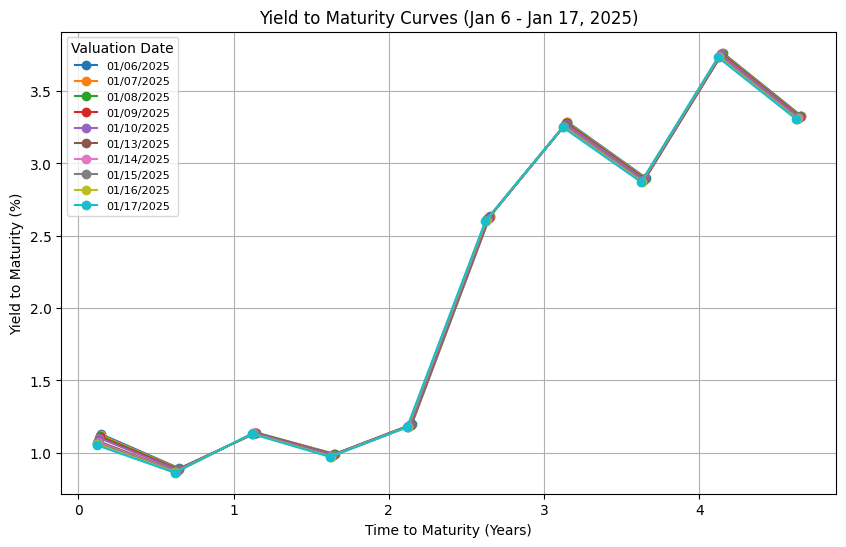

In [117]:
def process_ytm_curves(csv_file: str) -> None:
    """
    Process and generate YTM curves for bonds with maturity in March or September.
    This function now plots all YTM curves on a single graph with maturity capped at 5 years.

    :param csv_file: Path to sorted bond data CSV.
    """
    # Get the selected bonds
    selected_bonds = filter_bonds(csv_file)

    valuation_dates = [
        "01/06/2025", "01/07/2025", "01/08/2025", "01/09/2025",
        "01/10/2025", "01/13/2025", "01/14/2025", "01/15/2025",
        "01/16/2025", "01/17/2025"
    ]

    plt.figure(figsize=(10, 6))  # Create a single figure

    for valuation_date in valuation_dates:
        day = Day(valuation_date)
        day.add_bonds(selected_bonds)
        day.compute_dirty_prices()
        day.compute_ytms()
        
        maturities = [(bond.maturity_date - day.day).days / 365 for bond in selected_bonds]
        ytms = [ytm for _, ytm in day.yields]
        filtered_maturities = [m for m in maturities if m <= 5]
        filtered_ytms = [ytms[i] for i, m in enumerate(maturities) if m <= 5]
        plt.plot(filtered_maturities, filtered_ytms, marker='o', label=f"{valuation_date}")

    plt.title("Yield to Maturity Curves (Jan 6 - Jan 17, 2025)")
    plt.xlabel("Time to Maturity (Years)")
    plt.ylabel("Yield to Maturity (%)")
    plt.grid(True)
    plt.legend(loc='upper left', fontsize=8, title="Valuation Date")
    plt.show()

csv_file = "sorted_bond_data.csv"
process_ytm_curves(csv_file)

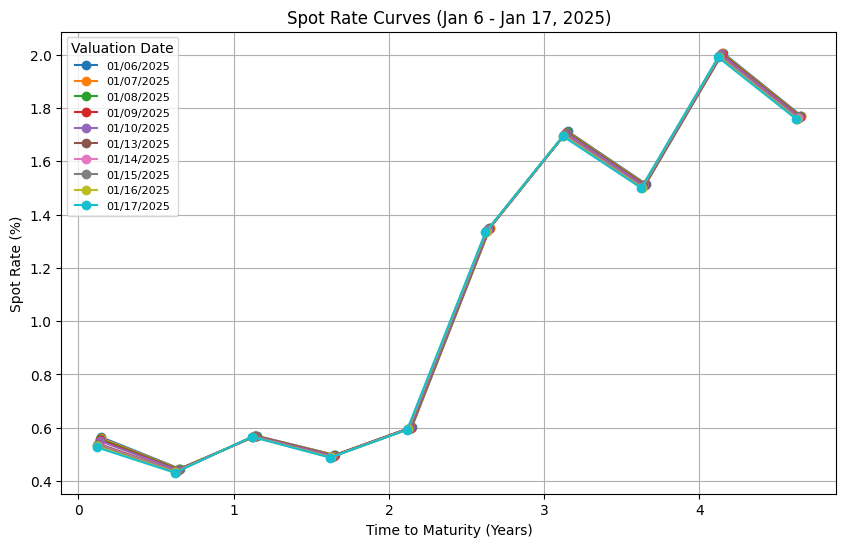

In [100]:
def process_spot_rate_curves(csv_file: str) -> None:
    """
    Process and generate spot rate curves for bonds with maturity in March or September.
    This function plots all spot rate curves on a single graph with maturity capped at 5 years.

    :param csv_file: Path to sorted bond data CSV.
    """
    selected_bonds = filter_bonds(csv_file)

    valuation_dates = [
        "01/06/2025", "01/07/2025", "01/08/2025", "01/09/2025",
        "01/10/2025", "01/13/2025", "01/14/2025", "01/15/2025",
        "01/16/2025", "01/17/2025"
    ]

    plt.figure(figsize=(10, 6))  # Create a single figure

    for valuation_date in valuation_dates:
        day = Day(valuation_date)
        day.add_bonds(selected_bonds)
        day.compute_dirty_prices()
        day.compute_spot_rates() 
        
        maturities = [(bond.maturity_date - day.day).days / 365 for bond in selected_bonds]
        spot_rates = day.spot_rates * 100
        filtered_maturities = [m for m in maturities if m <= 5]
        filtered_spot_rates = [spot_rates[i] for i, m in enumerate(maturities) if m <= 5]
        plt.plot(filtered_maturities, filtered_spot_rates, marker='o', label=f"{valuation_date}")

    plt.title("Spot Rate Curves (Jan 6 - Jan 17, 2025)")
    plt.xlabel("Time to Maturity (Years)")
    plt.ylabel("Spot Rate (%)")
    plt.grid(True)
    plt.legend(loc='upper left', fontsize=8, title="Valuation Date")
    plt.show()


csv_file = "sorted_bond_data.csv"
process_spot_rate_curves(csv_file)

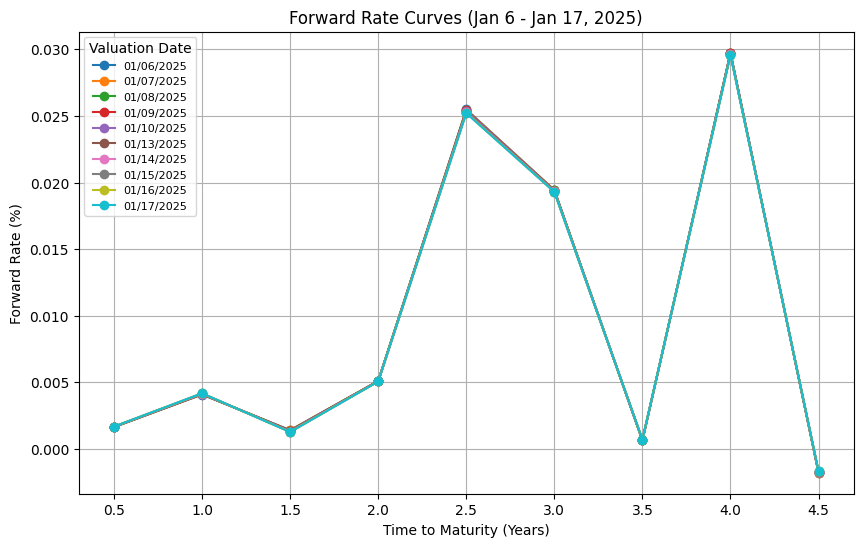

In [107]:
def plot_forward_rate_curves(csv_file: str) -> None:
    """
    Plot forward rate curves for each valuation date.
    
    :param csv_file: Path to sorted bond data CSV.
    """
    valuation_dates = [
    "01/06/2025", "01/07/2025", "01/08/2025", "01/09/2025",
    "01/10/2025", "01/13/2025", "01/14/2025", "01/15/2025",
    "01/16/2025", "01/17/2025"
    ]
    selected_bonds = filter_bonds(csv_file)
    plt.figure(figsize=(10, 6))

    for valuation_date in valuation_dates:
        day = Day(valuation_date)
        day.add_bonds(selected_bonds)
        day.compute_dirty_prices()
        day.compute_ytms()
        day.compute_spot_rates()
        day.compute_forward_rates()
        
        maturities = [(i + 1) / 2 for i in range(len(day.forward_rates))]
        plt.plot(maturities, day.forward_rates, marker='o', label=f"{valuation_date}")

    plt.title("Forward Rate Curves (Jan 6 - Jan 17, 2025)")
    plt.xlabel("Time to Maturity (Years)")
    plt.ylabel("Forward Rate (%)")
    plt.grid(True)
    plt.legend(loc='upper left', fontsize=8, title="Valuation Date")
    plt.show()
    
plot_forward_rate_curves(csv_file)

In [135]:
def compute_covariance_matrix_selected_bonds_yields(days):
    """
    Compute the covariance matrix for YTM log-returns for selected bonds.

    :param days: List of Day objects with computed YTMs.
    :return: Covariance matrix of log-returns for selected YTMs.
    """
    time_series_matrix = []
    
    selected_maturities = [0, 2, 4, 6, 8]
    for maturity_index in selected_maturities:
        maturity_time_series = []
        for day in days:
            if maturity_index < len(day.yields):
                _, yield_value = day.yields[maturity_index]
                maturity_time_series.append(float(yield_value))
            else:
                maturity_time_series.append(np.nan)

        time_series_matrix.append(maturity_time_series)

    rate_matrix = np.array(time_series_matrix, dtype=float)
    
    log_returns = np.zeros((rate_matrix.shape[0], rate_matrix.shape[1] - 1))  # Shape: (maturities, days-1)
    for i in range(rate_matrix.shape[0]):
        for j in range(rate_matrix.shape[1] - 1):
            if rate_matrix[i, j] > 0 and rate_matrix[i, j + 1] > 0:
                log_returns[i, j] = math.log(rate_matrix[i, j + 1] / rate_matrix[i, j])
            else:
                log_returns[i, j] = np.nan

    log_returns = np.nan_to_num(log_returns)
    covariance_matrix = np.cov(log_returns)
    return covariance_matrix

valuation_dates = [
    "01/06/2025", "01/07/2025", "01/08/2025", "01/09/2025",
    "01/10/2025", "01/13/2025", "01/14/2025", "01/15/2025",
    "01/16/2025", "01/17/2025"
]

days = []
for valuation_date in valuation_dates:
    day = Day(valuation_date)
    day.add_bonds(filter_bonds("bond_data.csv"))
    day.compute_dirty_prices()
    day.compute_ytms()
    days.append(day)

ytm_cov_matrix_selected = compute_covariance_matrix_selected_bonds_yields(days)
print("Covariance Matrix for Selected YTMs:")
print(ytm_cov_matrix_selected)

Covariance Matrix for Selected YTMs:
[[4.36993334e-06 2.03482442e-06 8.51445319e-07 1.28762064e-06
  1.09703912e-06]
 [2.03482442e-06 9.47582004e-07 3.96519768e-07 5.99640702e-07
  5.10891735e-07]
 [8.51445319e-07 3.96519768e-07 1.65928765e-07 2.50925947e-07
  2.13788862e-07]
 [1.28762064e-06 5.99640702e-07 2.50925947e-07 3.79463581e-07
  3.23302556e-07]
 [1.09703912e-06 5.10891735e-07 2.13788862e-07 3.23302556e-07
  2.75453641e-07]]


In [138]:
def compute_covariance_matrix_selected_bonds_forward_rates(days):
    """
    Compute the covariance matrix for forward rate log-returns for selected intervals.

    :param days: List of Day objects with computed forward rates.
    :return: Covariance matrix of log-returns for selected forward rates.
    """
    time_series_matrix = []

    for forward_index in range(4):
        forward_time_series = []
        for day in days:
            if forward_index < len(day.forward_rates):
                forward_time_series.append(day.forward_rates[forward_index])
            else:
                forward_time_series.append(np.nan)

        time_series_matrix.append(forward_time_series)

    rate_matrix = np.array(time_series_matrix, dtype=float)

    log_returns = np.zeros((rate_matrix.shape[0], rate_matrix.shape[1] - 1))
    for i in range(rate_matrix.shape[0]):
        for j in range(rate_matrix.shape[1] - 1):
            if rate_matrix[i, j] > 0 and rate_matrix[i, j + 1] > 0:
                log_returns[i, j] = math.log(rate_matrix[i, j + 1] / rate_matrix[i, j])
            else:
                log_returns[i, j] = np.nan

    log_returns = np.nan_to_num(log_returns)
    covariance_matrix = np.cov(log_returns)
    return covariance_matrix


valuation_dates = [
    "01/06/2025", "01/07/2025", "01/08/2025", "01/09/2025",
    "01/10/2025", "01/13/2025", "01/14/2025", "01/15/2025",
    "01/16/2025", "01/17/2025"
]

days = []
for valuation_date in valuation_dates:
    day = Day(valuation_date)
    day.add_bonds(filter_bonds("bond_data.csv"))  # Selected bonds are already filtered
    day.compute_dirty_prices()
    day.compute_ytms()
    day.compute_spot_rates()
    day.compute_forward_rates()
    days.append(day)
    
forward_cov_matrix_selected = compute_covariance_matrix_selected_bonds_forward_rates(days)
print("Covariance Matrix for Selected Forward Rates:")
print(forward_cov_matrix_selected)

Covariance Matrix for Selected Forward Rates:
[[ 1.87814392e-06  1.89102629e-06 -9.03647231e-06 -6.02255183e-07]
 [ 1.89102629e-06  1.90399891e-06 -9.09906266e-06 -6.06395660e-07]
 [-9.03647231e-06 -9.09906266e-06  4.36738041e-05  2.90075483e-06]
 [-6.02255183e-07 -6.06395660e-07  2.90075483e-06  1.93170464e-07]]


In [141]:
def compute_eigen_decomposition(cov_matrix, matrix_name):
    """
    Compute eigenvalues and eigenvectors of a covariance matrix and interpret the first eigenvalue.

    :param cov_matrix: Covariance matrix (numpy array).
    :param matrix_name: Name of the matrix for output purposes.
    """
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    print(f"\nEigenvalues of {matrix_name}:")
    print(eigenvalues)
    print(f"\nEigenvectors of {matrix_name}:")
    print(eigenvectors)

    print(f"\nInterpretation for {matrix_name}:")
    print(f"The largest eigenvalue is {eigenvalues[0]:.7f}, most variance.")
    print(f"The associated eigenvector is {eigenvectors[:, 0]}, direction of variance.")

    return eigenvalues, eigenvectors


ytm_eigenvalues, ytm_eigenvectors = compute_eigen_decomposition(ytm_cov_matrix_selected, "YTM Covariance Matrix")
forward_eigenvalues, forward_eigenvectors = compute_eigen_decomposition(forward_cov_matrix_selected, "Forward Rate Covariance Matrix")


Eigenvalues of YTM Covariance Matrix:
[ 6.13819957e-06  1.61761352e-10  1.24027129e-16  3.80682615e-23
 -2.83222975e-23]

Eigenvectors of YTM Covariance Matrix:
[[-8.43751745e-01  5.25545167e-01  1.08883044e-01  5.45076198e-03
  -7.46928510e-04]
 [-3.92897945e-01 -4.68668025e-01 -7.74505761e-01 -1.60591056e-01
  -2.21383274e-03]
 [-1.64405305e-01 -3.40253974e-01  3.85938502e-01 -3.80835800e-01
  -7.08967307e-01]
 [-2.48625295e-01 -4.55862540e-01  2.32474504e-01  8.21594836e-01
  -1.17600605e-01]
 [-2.11826714e-01 -4.24934274e-01  4.30456021e-01 -3.92589890e-01
   6.95363212e-01]]

Interpretation for YTM Covariance Matrix:
The largest eigenvalue is 0.0000061, most variance.
The associated eigenvector is [-0.84375174 -0.39289795 -0.16440531 -0.24862529 -0.21182671], direction of variance.

Eigenvalues of Forward Rate Covariance Matrix:
[4.76333285e-05 1.57888675e-08 1.78757222e-14 1.51534133e-20]

Eigenvectors of Forward Rate Covariance Matrix:
[[-1.98191948e-01  6.70796465e-01 -2.38141